## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp028'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.9),
        A.RandomBrightnessContrast(p=0.9),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.9),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

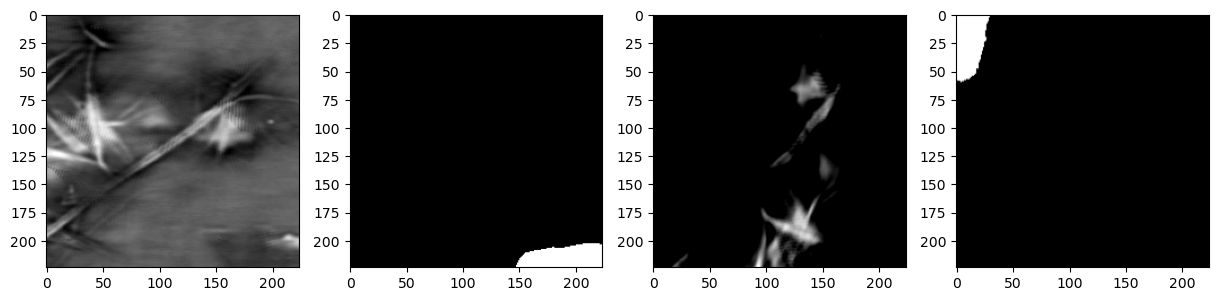

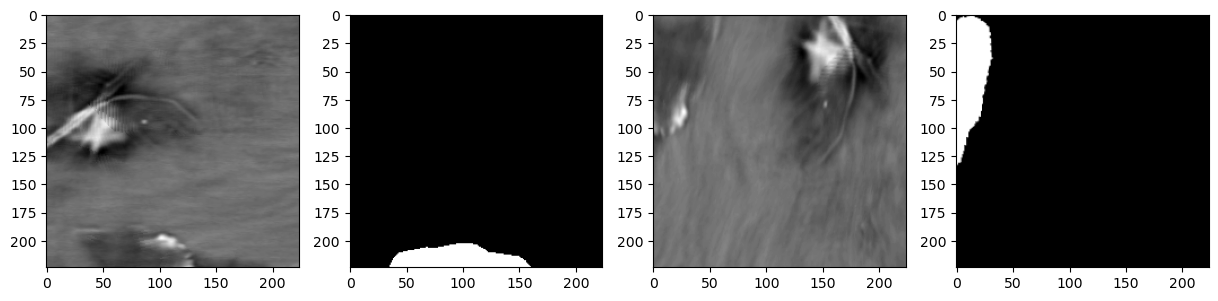

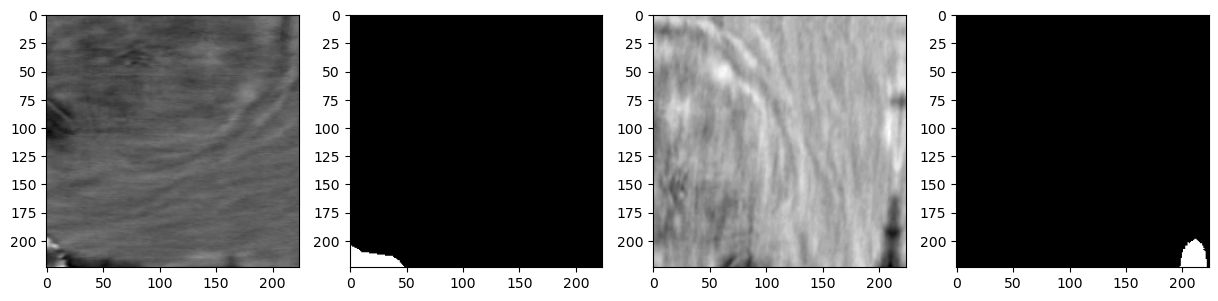

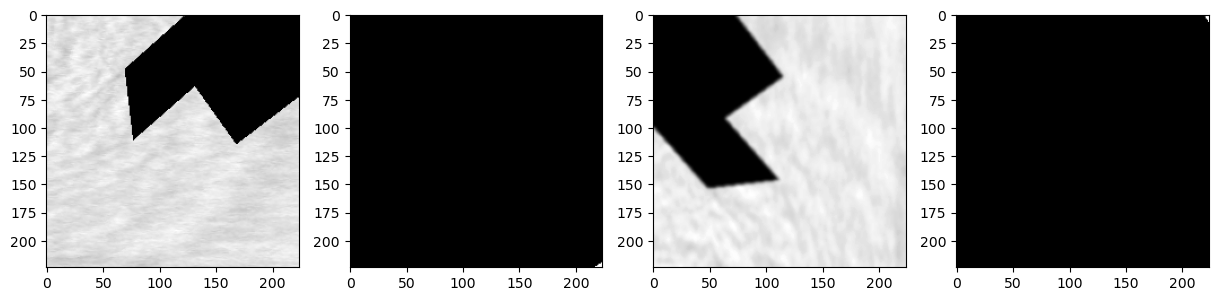

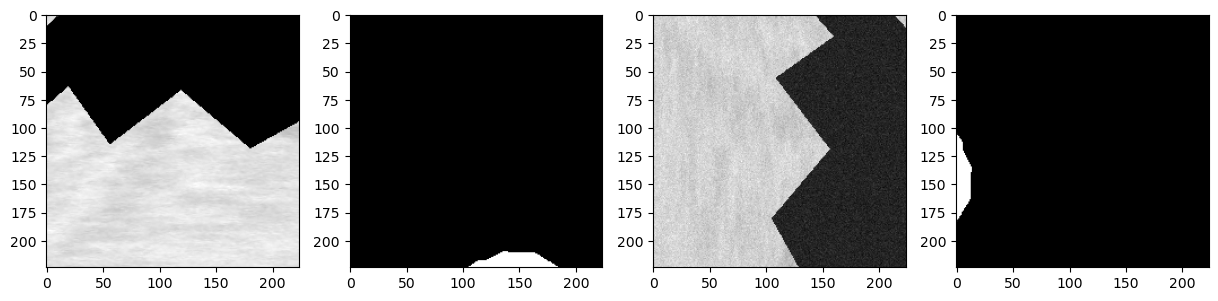

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48135

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096801224427764
th: 0.15, fbeta: 0.12101226347165636
th: 0.2, fbeta: 0.13750865796776857
th: 0.25, fbeta: 0.21906514784685377
th: 0.3, fbeta: 0.26104431695241137
th: 0.35, fbeta: 0.31555420078115165
th: 0.4, fbeta: 0.35829932289177124
th: 0.45, fbeta: 0.38358977971596625


best_th: 0.5, fbeta: 0.3884290322220182
Epoch 1 - avg_train_loss: 0.5786  avg_val_loss: 0.3982  time: 165s
Epoch 1 - avgScore: 0.3884
Epoch 1 - Save Best Score: 0.3884 Model
Epoch 1 - Save Best Loss: 0.3982 Model


th: 0.5, fbeta: 0.3884290322220182


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12097763311098375
th: 0.15, fbeta: 0.1937697603993686
th: 0.2, fbeta: 0.2386525724496853
th: 0.25, fbeta: 0.32734240189154507
th: 0.3, fbeta: 0.3750417322375754
th: 0.35, fbeta: 0.40270221887358115
th: 0.4, fbeta: 0.42064693267855724
th: 0.45, fbeta: 0.42840217391303054


best_th: 0.45, fbeta: 0.42840217391303054
Epoch 2 - avg_train_loss: 0.3884  avg_val_loss: 0.3316  time: 168s
Epoch 2 - avgScore: 0.4284
Epoch 2 - Save Best Score: 0.4284 Model
Epoch 2 - Save Best Loss: 0.3316 Model


th: 0.5, fbeta: 0.4243961642248671


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.36959037407134915
th: 0.15, fbeta: 0.43795690733178994
th: 0.2, fbeta: 0.466825981136274
th: 0.25, fbeta: 0.4771818973195518
th: 0.3, fbeta: 0.4796268785431411
th: 0.35, fbeta: 0.4759451182307186
th: 0.4, fbeta: 0.46797202352428285
th: 0.45, fbeta: 0.4521813723303059


best_th: 0.3, fbeta: 0.4796268785431411
Epoch 3 - avg_train_loss: 0.2962  avg_val_loss: 0.2444  time: 166s
Epoch 3 - avgScore: 0.4796
Epoch 3 - Save Best Score: 0.4796 Model
Epoch 3 - Save Best Loss: 0.2444 Model


th: 0.5, fbeta: 0.4242133710868923


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29193205893453694
th: 0.15, fbeta: 0.3364857565969897
th: 0.2, fbeta: 0.37993137994649906
th: 0.25, fbeta: 0.4134981941447218
th: 0.3, fbeta: 0.44055685490052476
th: 0.35, fbeta: 0.4620015297830422
th: 0.4, fbeta: 0.4722147698168812
th: 0.45, fbeta: 0.47392673936327956


best_th: 0.45, fbeta: 0.47392673936327956
Epoch 4 - avg_train_loss: 0.2620  avg_val_loss: 0.2287  time: 168s
Epoch 4 - avgScore: 0.4739


th: 0.5, fbeta: 0.4607910884958449


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2822845039519675
th: 0.15, fbeta: 0.3118546827756146
th: 0.2, fbeta: 0.33406938583537343
th: 0.25, fbeta: 0.3579236997560822
th: 0.3, fbeta: 0.38692918034050894
th: 0.35, fbeta: 0.4167149614021006
th: 0.4, fbeta: 0.44108676971313354
th: 0.45, fbeta: 0.4623832736737519


best_th: 0.5, fbeta: 0.4779655686997628
Epoch 5 - avg_train_loss: 0.2514  avg_val_loss: 0.2398  time: 169s
Epoch 5 - avgScore: 0.4780


th: 0.5, fbeta: 0.4779655686997628


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29898150883955577
th: 0.15, fbeta: 0.33422408592765623
th: 0.2, fbeta: 0.36578372242307683
th: 0.25, fbeta: 0.39137083022123614
th: 0.3, fbeta: 0.4139093854428442
th: 0.35, fbeta: 0.435117066961783
th: 0.4, fbeta: 0.45314730790209456
th: 0.45, fbeta: 0.46594665345113484


best_th: 0.5, fbeta: 0.4735567806064412
Epoch 6 - avg_train_loss: 0.2426  avg_val_loss: 0.2455  time: 169s
Epoch 6 - avgScore: 0.4736


th: 0.5, fbeta: 0.4735567806064412


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2924666054037042
th: 0.15, fbeta: 0.32088325397061934
th: 0.2, fbeta: 0.34514967973059424
th: 0.25, fbeta: 0.36686097556211544
th: 0.3, fbeta: 0.38770298825520605
th: 0.35, fbeta: 0.40643695945275116
th: 0.4, fbeta: 0.42444968737731475
th: 0.45, fbeta: 0.4427511387589534


best_th: 0.5, fbeta: 0.4594021677264315
Epoch 7 - avg_train_loss: 0.2351  avg_val_loss: 0.2724  time: 168s
Epoch 7 - avgScore: 0.4594


th: 0.5, fbeta: 0.4594021677264315


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3210716147617399
th: 0.15, fbeta: 0.35763142599152675
th: 0.2, fbeta: 0.3879285556004442
th: 0.25, fbeta: 0.4151549260297711
th: 0.3, fbeta: 0.4407319709198041
th: 0.35, fbeta: 0.4654864341560598
th: 0.4, fbeta: 0.4885759571454855
th: 0.45, fbeta: 0.5088609043241923


best_th: 0.5, fbeta: 0.5280749599347683
Epoch 8 - avg_train_loss: 0.2262  avg_val_loss: 0.2327  time: 167s
Epoch 8 - avgScore: 0.5281
Epoch 8 - Save Best Score: 0.5281 Model
Epoch 8 - Save Best Loss: 0.2327 Model


th: 0.5, fbeta: 0.5280749599347683


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3934503224631501
th: 0.15, fbeta: 0.45203574572118105
th: 0.2, fbeta: 0.48763210865158785
th: 0.25, fbeta: 0.5124683847251259
th: 0.3, fbeta: 0.5295623205464939
th: 0.35, fbeta: 0.5362586266211803
th: 0.4, fbeta: 0.5377451056763819
th: 0.45, fbeta: 0.5315959861251247


best_th: 0.4, fbeta: 0.5377451056763819
Epoch 9 - avg_train_loss: 0.2174  avg_val_loss: 0.2266  time: 167s
Epoch 9 - avgScore: 0.5377
Epoch 9 - Save Best Score: 0.5377 Model
Epoch 9 - Save Best Loss: 0.2266 Model


th: 0.5, fbeta: 0.518146563377563


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31437990004810806
th: 0.15, fbeta: 0.34823904763487723
th: 0.2, fbeta: 0.3783577093202172
th: 0.25, fbeta: 0.40396461742756673
th: 0.3, fbeta: 0.43157658016222433
th: 0.35, fbeta: 0.458388095609826
th: 0.4, fbeta: 0.4800075564861434
th: 0.45, fbeta: 0.4987916316707076


best_th: 0.5, fbeta: 0.5160941229874372
Epoch 10 - avg_train_loss: 0.2108  avg_val_loss: 0.2399  time: 167s
Epoch 10 - avgScore: 0.5161


th: 0.5, fbeta: 0.5160941229874372


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41335272378276006
th: 0.15, fbeta: 0.45726704100879095
th: 0.2, fbeta: 0.48433228626286057
th: 0.25, fbeta: 0.5091330968806664
th: 0.3, fbeta: 0.5305792700428821
th: 0.35, fbeta: 0.5424145675731906
th: 0.4, fbeta: 0.544504007065853
th: 0.45, fbeta: 0.5382224119864695


best_th: 0.4, fbeta: 0.544504007065853
Epoch 11 - avg_train_loss: 0.2011  avg_val_loss: 0.2315  time: 165s
Epoch 11 - avgScore: 0.5445
Epoch 11 - Save Best Score: 0.5445 Model
Epoch 11 - Save Best Loss: 0.2315 Model


th: 0.5, fbeta: 0.521249701361739


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3860127133938243
th: 0.15, fbeta: 0.42258434405994316
th: 0.2, fbeta: 0.45396031644556467
th: 0.25, fbeta: 0.48275942447732145
th: 0.3, fbeta: 0.510021080791097
th: 0.35, fbeta: 0.5330500258170977
th: 0.4, fbeta: 0.5472034326743567
th: 0.45, fbeta: 0.5556195056311831


best_th: 0.45, fbeta: 0.5556195056311831
Epoch 12 - avg_train_loss: 0.1924  avg_val_loss: 0.2389  time: 167s
Epoch 12 - avgScore: 0.5556
Epoch 12 - Save Best Score: 0.5556 Model
Epoch 12 - Save Best Loss: 0.2389 Model


th: 0.5, fbeta: 0.5553393345068846


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4141143755723791
th: 0.15, fbeta: 0.4635291297339278
th: 0.2, fbeta: 0.4933500977741458
th: 0.25, fbeta: 0.518003634038751
th: 0.3, fbeta: 0.5378083284457164
th: 0.35, fbeta: 0.5488288706147728
th: 0.4, fbeta: 0.5544314794956916
th: 0.45, fbeta: 0.5569363852078342


best_th: 0.45, fbeta: 0.5569363852078342
Epoch 13 - avg_train_loss: 0.1865  avg_val_loss: 0.2413  time: 167s
Epoch 13 - avgScore: 0.5569
Epoch 13 - Save Best Score: 0.5569 Model
Epoch 13 - Save Best Loss: 0.2413 Model


th: 0.5, fbeta: 0.5534662624419283


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3471045987688535
th: 0.15, fbeta: 0.367356628616994
th: 0.2, fbeta: 0.38621984040517104
th: 0.25, fbeta: 0.4029862075814119
th: 0.3, fbeta: 0.41994165341686723
th: 0.35, fbeta: 0.43678916179017907
th: 0.4, fbeta: 0.4532035344331658
th: 0.45, fbeta: 0.4662826224859734


best_th: 0.5, fbeta: 0.47597523773878025
Epoch 14 - avg_train_loss: 0.1777  avg_val_loss: 0.2761  time: 168s
Epoch 14 - avgScore: 0.4760


th: 0.5, fbeta: 0.47597523773878025


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3961936627638703
th: 0.15, fbeta: 0.4380109577392536
th: 0.2, fbeta: 0.47049244806266666
th: 0.25, fbeta: 0.49956945028550687
th: 0.3, fbeta: 0.5236803524760986
th: 0.35, fbeta: 0.5413818891137695
th: 0.4, fbeta: 0.555966898216787
th: 0.45, fbeta: 0.5618130530309934


best_th: 0.45, fbeta: 0.5618130530309934
Epoch 15 - avg_train_loss: 0.1710  avg_val_loss: 0.2414  time: 167s
Epoch 15 - avgScore: 0.5618
Epoch 15 - Save Best Score: 0.5618 Model
Epoch 15 - Save Best Loss: 0.2414 Model


th: 0.5, fbeta: 0.5608431268871461


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3942260980894327
th: 0.15, fbeta: 0.43078720238957835
th: 0.2, fbeta: 0.4613964969436104
th: 0.25, fbeta: 0.4849389498331379
th: 0.3, fbeta: 0.5043148772612152
th: 0.35, fbeta: 0.5214176682656758
th: 0.4, fbeta: 0.5350604709251366
th: 0.45, fbeta: 0.5419860351960927


best_th: 0.5, fbeta: 0.5420430507509697
Epoch 16 - avg_train_loss: 0.1641  avg_val_loss: 0.2618  time: 169s
Epoch 16 - avgScore: 0.5420


th: 0.5, fbeta: 0.5420430507509697


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3755425078894309
th: 0.15, fbeta: 0.39819945613618496
th: 0.2, fbeta: 0.42253124140408993
th: 0.25, fbeta: 0.4454241313714394
th: 0.3, fbeta: 0.46290459960236224
th: 0.35, fbeta: 0.4801487777267456
th: 0.4, fbeta: 0.496333696277162
th: 0.45, fbeta: 0.5102015646515072


best_th: 0.5, fbeta: 0.5183869163355034
Epoch 17 - avg_train_loss: 0.1556  avg_val_loss: 0.2870  time: 168s
Epoch 17 - avgScore: 0.5184


th: 0.5, fbeta: 0.5183869163355034


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3674816518017148
th: 0.15, fbeta: 0.38984692487256134
th: 0.2, fbeta: 0.413626945729529
th: 0.25, fbeta: 0.43164447864999195
th: 0.3, fbeta: 0.4473056129714041
th: 0.35, fbeta: 0.46334013822026937
th: 0.4, fbeta: 0.4794460769340889
th: 0.45, fbeta: 0.4939124492918351


best_th: 0.5, fbeta: 0.5060026031913728
Epoch 18 - avg_train_loss: 0.1474  avg_val_loss: 0.2852  time: 167s
Epoch 18 - avgScore: 0.5060


th: 0.5, fbeta: 0.5060026031913728


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3556383279516128
th: 0.15, fbeta: 0.3855096979479374
th: 0.2, fbeta: 0.4134169680262603
th: 0.25, fbeta: 0.4378487597955329
th: 0.3, fbeta: 0.4607861889227602
th: 0.35, fbeta: 0.48460866105418504
th: 0.4, fbeta: 0.507786591720549
th: 0.45, fbeta: 0.5281900340576292


best_th: 0.5, fbeta: 0.5446797940717778
Epoch 19 - avg_train_loss: 0.1433  avg_val_loss: 0.2631  time: 168s
Epoch 19 - avgScore: 0.5447


th: 0.5, fbeta: 0.5446797940717778


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38149336508268816
th: 0.15, fbeta: 0.4136693772499276
th: 0.2, fbeta: 0.44146702168629137
th: 0.25, fbeta: 0.46539838316443605
th: 0.3, fbeta: 0.48602093799403023
th: 0.35, fbeta: 0.5042926827519405
th: 0.4, fbeta: 0.5196045987607337
th: 0.45, fbeta: 0.5268225013604806


best_th: 0.5, fbeta: 0.5312826196160574
Epoch 20 - avg_train_loss: 0.1372  avg_val_loss: 0.2743  time: 167s
Epoch 20 - avgScore: 0.5313


th: 0.5, fbeta: 0.5312826196160574


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40766911979487575
th: 0.15, fbeta: 0.4419695672063814
th: 0.2, fbeta: 0.4678931557964524
th: 0.25, fbeta: 0.49011384610393405
th: 0.3, fbeta: 0.5075962941877992
th: 0.35, fbeta: 0.5247339974287971
th: 0.4, fbeta: 0.5393539662536327
th: 0.45, fbeta: 0.5490628176057347


best_th: 0.5, fbeta: 0.552791193472125
Epoch 21 - avg_train_loss: 0.1306  avg_val_loss: 0.2622  time: 168s
Epoch 21 - avgScore: 0.5528


th: 0.5, fbeta: 0.552791193472125


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35710348460890995
th: 0.15, fbeta: 0.38433982489522217
th: 0.2, fbeta: 0.4084358811723619
th: 0.25, fbeta: 0.4310735324644441
th: 0.3, fbeta: 0.45272013660517246
th: 0.35, fbeta: 0.4706222147000519
th: 0.4, fbeta: 0.488485994567043
th: 0.45, fbeta: 0.5025237264327561


best_th: 0.5, fbeta: 0.5116254877621966
Epoch 22 - avg_train_loss: 0.1273  avg_val_loss: 0.2880  time: 167s
Epoch 22 - avgScore: 0.5116


th: 0.5, fbeta: 0.5116254877621966


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42085092415211517
th: 0.15, fbeta: 0.4523981031212843
th: 0.2, fbeta: 0.4768272700944488
th: 0.25, fbeta: 0.49877432610668543
th: 0.3, fbeta: 0.513844910432737
th: 0.35, fbeta: 0.5239885163758934
th: 0.4, fbeta: 0.5293828019718396
th: 0.45, fbeta: 0.5308669073602529


best_th: 0.45, fbeta: 0.5308669073602529
Epoch 23 - avg_train_loss: 0.1214  avg_val_loss: 0.2968  time: 167s
Epoch 23 - avgScore: 0.5309


th: 0.5, fbeta: 0.5294689680987551


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4032465075241408
th: 0.15, fbeta: 0.4348271907522448
th: 0.2, fbeta: 0.4611535333284423
th: 0.25, fbeta: 0.48156109759901766
th: 0.3, fbeta: 0.49961685982959175
th: 0.35, fbeta: 0.5114315971093941
th: 0.4, fbeta: 0.5176470694219731
th: 0.45, fbeta: 0.5211892032698302


best_th: 0.45, fbeta: 0.5211892032698302
Epoch 24 - avg_train_loss: 0.1195  avg_val_loss: 0.2914  time: 167s
Epoch 24 - avgScore: 0.5212


th: 0.5, fbeta: 0.5197834819001821


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4442944764162746
th: 0.15, fbeta: 0.4759501814721904
th: 0.2, fbeta: 0.5006276804325295
th: 0.25, fbeta: 0.5185757912932036
th: 0.3, fbeta: 0.5286784682126712
th: 0.35, fbeta: 0.5341897951324946
th: 0.4, fbeta: 0.5374170742256028
th: 0.45, fbeta: 0.5389855404149968


best_th: 0.45, fbeta: 0.5389855404149968
Epoch 25 - avg_train_loss: 0.1150  avg_val_loss: 0.3182  time: 168s
Epoch 25 - avgScore: 0.5390


th: 0.5, fbeta: 0.5339643266825349


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39665279888651206
th: 0.15, fbeta: 0.42972823826788775
th: 0.2, fbeta: 0.456672748945079
th: 0.25, fbeta: 0.47981915260137475
th: 0.3, fbeta: 0.49884192279372547
th: 0.35, fbeta: 0.5112076277932881
th: 0.4, fbeta: 0.5191973399799575
th: 0.45, fbeta: 0.5224708353561447


best_th: 0.45, fbeta: 0.5224708353561447
Epoch 26 - avg_train_loss: 0.1117  avg_val_loss: 0.3135  time: 167s
Epoch 26 - avgScore: 0.5225


th: 0.5, fbeta: 0.5217743753746286


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4212392599192902
th: 0.15, fbeta: 0.4519679022179177
th: 0.2, fbeta: 0.4798102464388906
th: 0.25, fbeta: 0.5051484583154853
th: 0.3, fbeta: 0.5217359749910182
th: 0.35, fbeta: 0.5314734421201575
th: 0.4, fbeta: 0.5334958306822863
th: 0.45, fbeta: 0.5324990409753911


best_th: 0.4, fbeta: 0.5334958306822863
Epoch 27 - avg_train_loss: 0.1109  avg_val_loss: 0.3181  time: 169s
Epoch 27 - avgScore: 0.5335


th: 0.5, fbeta: 0.5313263524068133


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43127168942436367
th: 0.15, fbeta: 0.46071917242785965
th: 0.2, fbeta: 0.48524963912242886
th: 0.25, fbeta: 0.5057692978473233
th: 0.3, fbeta: 0.5175691635187379
th: 0.35, fbeta: 0.5250997452957734
th: 0.4, fbeta: 0.5289053999085572
th: 0.45, fbeta: 0.5294552412866685


best_th: 0.45, fbeta: 0.5294552412866685
Epoch 28 - avg_train_loss: 0.1082  avg_val_loss: 0.3272  time: 168s
Epoch 28 - avgScore: 0.5295


th: 0.5, fbeta: 0.5256371910697368


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4439232384676773
th: 0.15, fbeta: 0.4762810791500971
th: 0.2, fbeta: 0.5013383132891971
th: 0.25, fbeta: 0.5199133359218043
th: 0.3, fbeta: 0.529616948648196
th: 0.35, fbeta: 0.5331755548931681
th: 0.4, fbeta: 0.5335840348517263
th: 0.45, fbeta: 0.5315620135559559


best_th: 0.4, fbeta: 0.5335840348517263
Epoch 29 - avg_train_loss: 0.1067  avg_val_loss: 0.3271  time: 168s
Epoch 29 - avgScore: 0.5336


th: 0.5, fbeta: 0.523505267662543


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42296563400495923
th: 0.15, fbeta: 0.45166153606428977
th: 0.2, fbeta: 0.4774298841553031
th: 0.25, fbeta: 0.49993290841716553
th: 0.3, fbeta: 0.5136083419816121
th: 0.35, fbeta: 0.5207829519741788
th: 0.4, fbeta: 0.5243839222627403
th: 0.45, fbeta: 0.5267967520484583


best_th: 0.45, fbeta: 0.5267967520484583
Epoch 30 - avg_train_loss: 0.1061  avg_val_loss: 0.3227  time: 168s
Epoch 30 - avgScore: 0.5268


th: 0.5, fbeta: 0.5244331649051635


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3961936627638703
th: 0.15, fbeta: 0.4380109577392536
th: 0.2, fbeta: 0.47049244806266666
th: 0.25, fbeta: 0.49956945028550687
th: 0.3, fbeta: 0.5236803524760986
th: 0.35, fbeta: 0.5413818891137695
th: 0.4, fbeta: 0.555966898216787
th: 0.45, fbeta: 0.5618130530309934


best_th: 0.45, fbeta: 0.5618130530309934


th: 0.5, fbeta: 0.5608431268871461


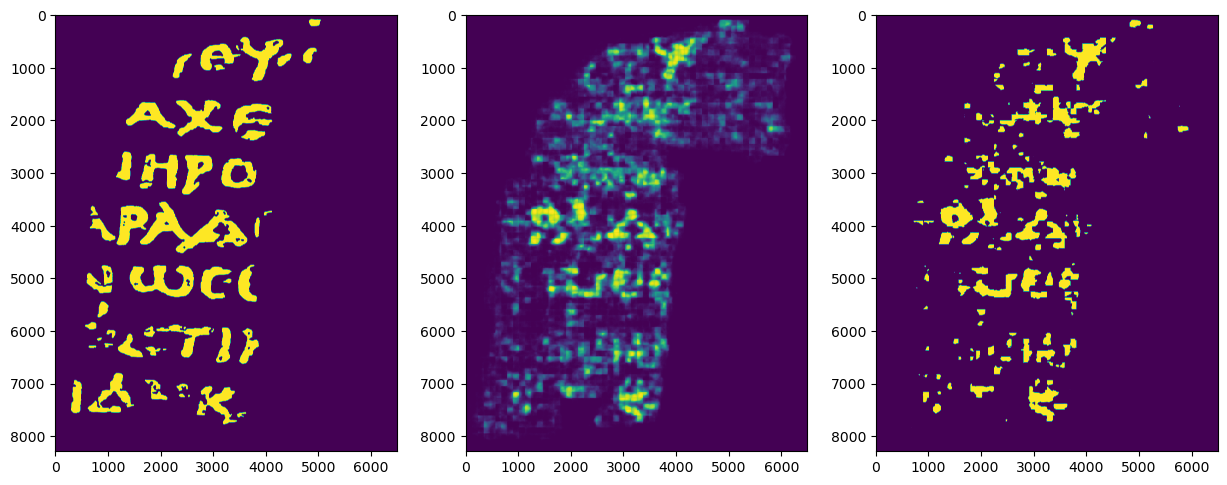

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([38366361.,  4038702.,  2300544.,  1550340.,  1195503.,   929638.,
          766590.,   661575.,   573259.,   472872.,   414203.,   393018.,
          353752.,   306080.,   277193.,   253186.,   269017.,   274388.,
          261015.,   181612.]),
 array([4.71041967e-05, 4.97568407e-02, 9.94665771e-02, 1.49176314e-01,
        1.98886050e-01, 2.48595787e-01, 2.98305523e-01, 3.48015260e-01,
        3.97724996e-01, 4.47434732e-01, 4.97144469e-01, 5.46854205e-01,
        5.96563942e-01, 6.46273678e-01, 6.95983415e-01, 7.45693151e-01,
        7.95402888e-01, 8.45112624e-01, 8.94822361e-01, 9.44532097e-01,
        9.94241834e-01]),
 <BarContainer object of 20 artists>)

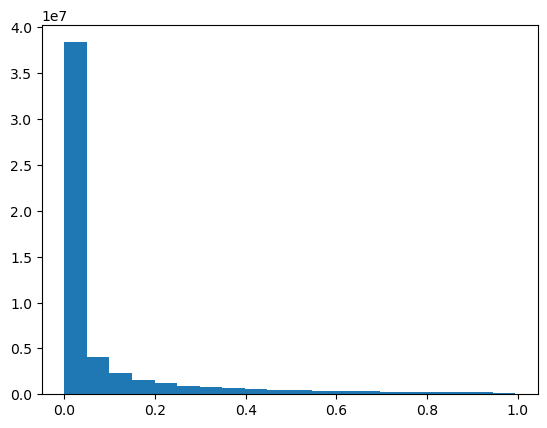

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000